In [ ]:
%load_ext autoreload
%autoreload 2

# 01 Basics: design and rendering

## What we will learn about
- Keeping the design tidy: groups and name conventions
- Design variables
- MiniStudies

## What we will do
- Transform the resonator length into a design variable
- Write a MiniStudy that isolates the resonator

In [ ]:
# Library imports
import json
from qdesignoptimizer.utils.chip_generation import create_chip_base, ChipType

# Project specific
from design import *
import names as n

## Rendering the design

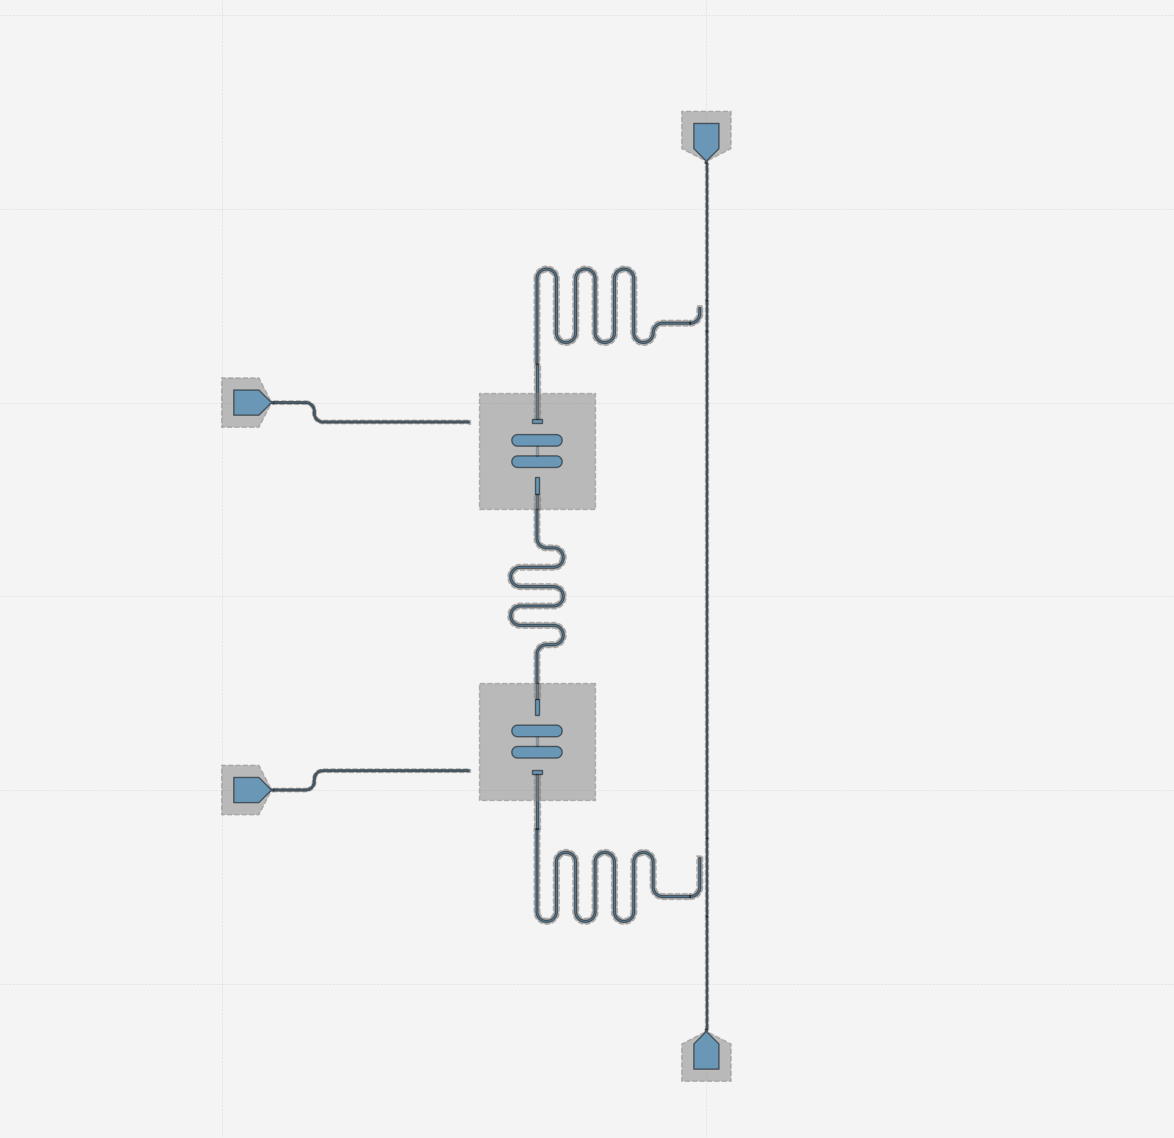

### 1. Create the chip

In [ ]:
def create_chip_and_gui():
    # Initialize the chip and open the Qiskit Metal GUI.
    chip_type = ChipType(
        size_x="10mm", size_y="10mm", size_z="-300um", material="silicon"
    )
    design, gui = create_chip_base(
        chip_name=n.CHIP_NAME, chip_type=chip_type, open_gui=True
    )

    # Pick the values for the design variables defined in the .json file
    # and add them to the design object created by Qiskit Metal
    with open("design_variables.json") as in_file:
        initial_design_variables = json.load(in_file)
    n.add_design_variables_to_design(design, initial_design_variables)

    return design, gui


design, gui = create_chip_and_gui()

### 2. Call the functions defined in design.py

In [ ]:
def render_qiskit_metal_design(design, gui):
    add_transmon_plus_resonator(design, group=n.NBR_1)
    add_transmon_plus_resonator(design, group=n.NBR_2)

    add_coupler(design)

    add_route_interconnects(design)

    add_launch_pads(design)

    add_chargeline(design, group=n.NBR_1)
    add_chargeline(design, group=n.NBR_2)

    gui.rebuild()
    gui.autoscale()


render_qiskit_metal_design(design, gui)
gui.screenshot()

# 02 Optimization of readout resonator frequency

## What we will learn about
- Optimization and parameter targets
- Plotting optimization results
- What happens when running the optimization

## What we will do
- Write parameter and optimization targets for the readout resonator's frequency
- Configure a simple plot for the optimization results

In [ ]:
# Library imports
import os
from qdesignoptimizer.design_analysis import DesignAnalysis, DesignAnalysisState
from qdesignoptimizer.utils.utils import get_save_path
from qdesignoptimizer.utils.utils import close_ansys

# Project-specific imports
import names as n
import mini_studies as ms
import optimization_targets as ot
import parameter_targets as pt
import plot_settings as ps
from design import render_qiskit_metal_design, create_chip_and_gui

os.makedirs(os.path.dirname("out/"), exist_ok=True)

## Creating the study and optimization targets

In [ ]:
MINI_STUDY_GROUP = n.NBR_1

RENDER_QISKIT_METAL = lambda design: render_qiskit_metal_design(design, gui)
MINI_STUDY = ms.get_mini_study_resonator_only(group=MINI_STUDY_GROUP)
opt_targets = ot.get_opt_target_res_freq_via_length(
    MINI_STUDY_GROUP,
)
plot_settings = ps.get_plot_settings_resonator(MINI_STUDY_GROUP)

## Initialization of the DesignAnalysis objects

In [ ]:
design_analysis_state = DesignAnalysisState(
    design, RENDER_QISKIT_METAL, pt.PARAM_TARGETS
)

design_analysis = DesignAnalysis(
    design_analysis_state,
    mini_study=MINI_STUDY,
    opt_targets=opt_targets,
    save_path=get_save_path("out/", n.CHIP_NAME),
    update_design_variables=False,
    plot_settings=plot_settings,
)

## Running the optimization

In [ ]:
group_runs = 3
group_passes = 8
design_analysis.update_nbr_passes(group_passes)

for i in range(group_runs):
    design_analysis.optimize_target({}, {})
    design_analysis.screenshot(gui=gui, run=i)

## Results

For group 1

![image info](./plots/resonator_frequency_1.png)

For group 2

![image info](./plots/resonator_frequency_2.png)


In [ ]:
design_analysis.get_eigenmode_results()

# 03 Adding more parameters

## What we will learn about
- Defining a MiniStudy containing a Josephson junction and multiple modes.
- Using parameters targeting nonlinearities.


## Now it is your time to extend the example!
### Goal: also optimize the qubit frequency, its anharmonicity and resonator-qubit chi.
### TODO
- Add a function called ``get_mini_study_resonator_qubit`` to the mini-studies file that isolates the qubit and readout resonator.
- Transform the inductance of the qubit's Josephson junction into a design variable.
- Add the targets for the new parameters to the corresponding file. Import and use ``param_nonlin`` to define targets for $\chi$ and the anharmonicity.
- Add a function called ``get_opt_targets_resonator_qubit`` to the optimization targets file. Use the targets predefined in the library.
- Add a function called ``get_plot_settings_resonator_qubit`` to the optimization targets file. Plot the qubit frequency in the same panel as the resonator frequency, while $\chi$ and the qubit anharmonicity should appear in a new panel. 

In [ ]:
MINI_STUDY_GROUP = n.NBR_1
RENDER_QISKIT_METAL = lambda design: render_qiskit_metal_design(design, gui)
MINI_STUDY = ms.get_mini_study_resonator_qubit(group=MINI_STUDY_GROUP)
opt_targets = ot.get_opt_target_resonator_qubit(MINI_STUDY_GROUP)
plot_settings = ps.get_plot_settings_resonator_qubit(MINI_STUDY_GROUP)